# Shapelet based time series machine learning

Shapelets a subsections of times series taken from the train data that are a useful for time series machine learning. They were first proposed ia primitive for machine learning [1][2] and were embedded in a decision tree for classification. The Shapelet Transform Classifier (STC)[3,4] is a pipeline classifier which searches the training data for shapelets, transforms series to vectors of distances to a filtered set of selected shapelets based on information gain, then builds a classifier on the latter.

Finding shapelets involves selecting and evaluating shapelets. The original shapelet tree and STC performed a full enumeration of all possible shapelets before keeping the best ones. This is computationally inefficient, and modern shapelet based machine learning algorithms randomise the search.

In [2]:
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from aeon.datasets import load_basic_motions
from aeon.registry import all_estimators
from aeon.transformations.collection.shapelet_based import RandomShapeletTransform

warnings.filterwarnings("ignore")
all_estimators("classifier", filter_tags={"algorithm_type": "shapelet"})

[('ShapeletTransformClassifier',
  aeon.classification.shapelet_based._stc.ShapeletTransformClassifier)]

### Shapelet Transform for Classification

The `RandomShapeletTransform` transformer takes a set of labelled training time series in the `fit` function, randomly samples `n_shapelet_samples`  shapelets, keeping the best  `max_shapelets`. The resulting shapelets are used in the `transform` function to create a new tabular dataset, where each row represents a time series instance, and each column stores the distance from a time series to a shapelet. The resulting tabular data can be used by any scikit learn compatible classifier. In this notebook we will explain these terms and describe how the algorithm works. But first we show it in action. We will use the BasicMotions data as an example. This data set contains time series of motion traces for the activities "running", "walking", "standing" and "badminton". The learning problem is to predict the activity given the time series. Each time series has six channels: x, y, z position and x, y, z accelerometer of the wrist. Data was recorded on a smart watch.

In [ ]:
X, y = load_basic_motions(split="train")
rst = RandomShapeletTransform(n_shapelet_samples=100, max_shapelets=10, random_state=42)
st = rst.fit_transform(X, y)
print(" Shape of transformed data = ", st.shape)
print(" Distance of second series to third shapelet = ", st[1][2])
testX, testy = load_basic_motions(split="test")
tr_test = rst.transform(testX)
rf = RandomForestClassifier(random_state=10)
rf.fit(st, y)
preds = rf.predict(tr_test)
print(" Shapelets + random forest acc = ", accuracy_score(preds, testy))

### Visualising Shapelets
The first column of the transformed data represents the distance from the first shapelet to each time series. The shapelets are sorted, so the first shapelet is the one we estimate is the best (using the calculation described below). You can recover the shapelets from the transform. Each shapelet is a 7-tuple, storing the following information:

In [44]:
running_shapelet = rst.shapelets[0]
print("Quality = ", running_shapelet[0])
print("Length = ", running_shapelet[1])
print("position = ", running_shapelet[2])
print("Channel = ", running_shapelet[3])
print("Origin Instance Index = ", running_shapelet[4])
print("Class label = ", running_shapelet[5])
print("Shapelet = ", running_shapelet[6])

Quality =  0.8112781244589999
Length =  38
position =  8
Channel =  0
Origin Instance Index =  13
Class label =  running
Shapelet =  [ 0.80928584  1.26598641  1.26598641  0.50311921  0.63023046  0.63023046
  0.11160244 -1.38265413 -2.42561733 -0.63775503  0.51153018  0.51153018
  0.49074957  0.9142872   0.62033438  0.119901   -1.85423662 -2.14976266
 -0.0038555   0.91317676  0.10631423  0.28619945  0.21756569  0.40019312
 -0.00474682 -1.59844468 -1.59844468 -0.25564779  1.08972374  0.66380345
  0.71833283  0.7425672   0.3354944   0.14130263 -1.59331817 -1.59331817
  0.54917717  0.54917717]


We can directly extract shapelets and inspect them. These are the the two shapelets that are best at discriminating badminton and running against other activities. All shapelets are normalised to provide scale invariance.

 walking shapelet from channel  (0.616271397965, 12, 24, 0, 32, 'badminton', array([-0.64704846, -0.6359159 , -0.6027561 , -0.60881816, -0.58686402,
       -0.51156492, -0.44793226, -0.04608355,  0.71941478,  2.12366136,
        2.00632024, -0.76241302]))


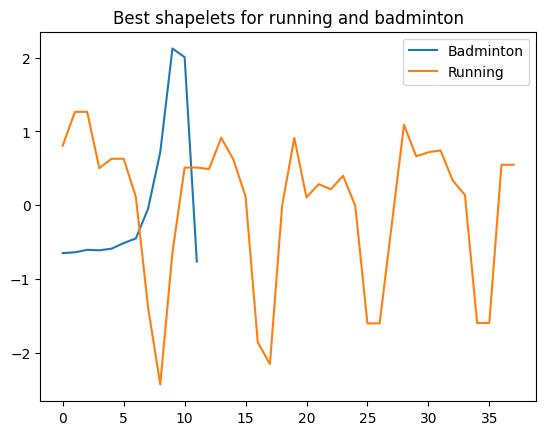

In [47]:
import matplotlib.pyplot as plt

badminton_shapelet = rst.shapelets[4]
print(" Badminton shapelet from channel 0 (x-dimension)", badminton_shapelet)
plt.title("Best shapelets for running and badminton")
plt.plot(badminton_shapelet[6], label="Badminton")
plt.plot(running_shapelet[6], label="Running")
plt.legend()

Both shapelets are in the x-axis, so represent side to side motion. Badminton is characterised by sa single large peak in one direction, capturing the drawing of the hand back and quickly hittig the shuttlcock. Running is chaaracterised by a longer repetition of side to side motions, with a sharper peak representing bringing the arm forward accross the body in a running motion.

## Performance on the UCR univariate datasets

You can find the interval based classifiers as follows.

In [1]:
from aeon.registry import all_estimators

est = all_estimators("classifier", filter_tags={"algorithm_type": "shapelet"})
for c in est:
    print(c)

('MrSQMClassifier', <class 'aeon.classification.shapelet_based._mrsqm.MrSQMClassifier'>)
('RDSTClassifier', <class 'aeon.classification.shapelet_based._rdst.RDSTClassifier'>)
('ShapeletTransformClassifier', <class 'aeon.classification.shapelet_based._stc.ShapeletTransformClassifier'>)


In [2]:
from aeon.benchmarking import get_estimator_results_as_array
from aeon.datasets.tsc_data_lists import univariate

names = [t[0].replace("Classifier", "") for t in est]
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape

(112, 3)

(<Figure size 600x220 with 1 Axes>, <Axes: >)

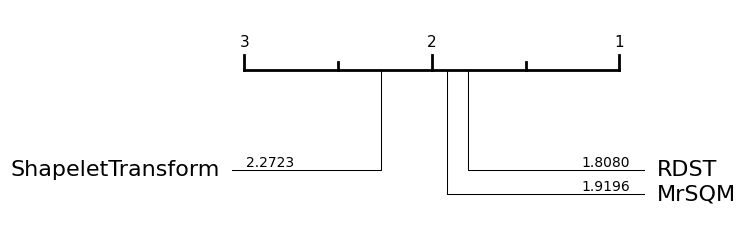

In [3]:
from aeon.visualisation import plot_boxplot_median, plot_critical_difference

plot_critical_difference(results, names)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

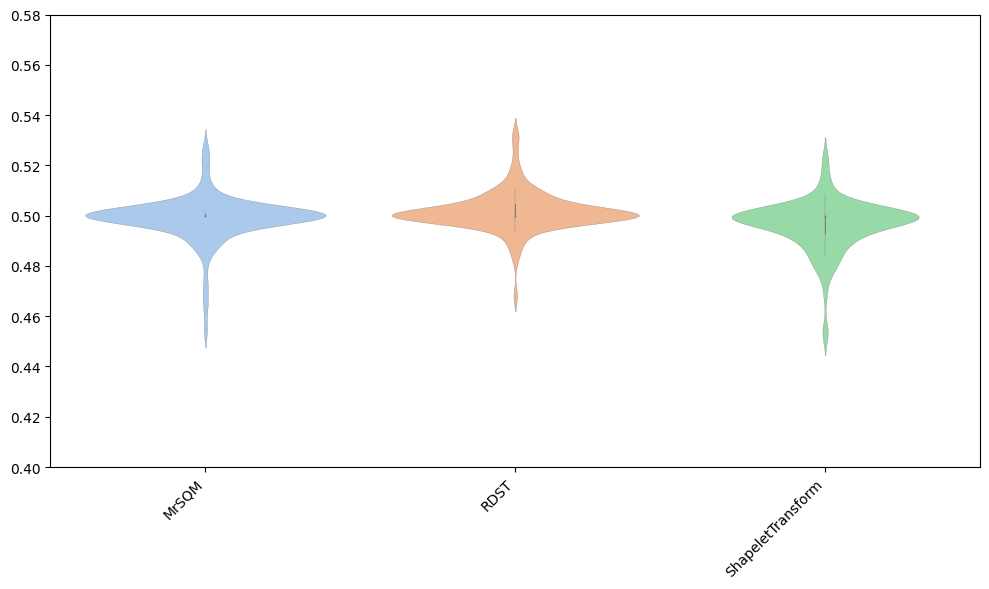

In [4]:
plot_boxplot_median(results, names)